In [ ]:
import torch
import torch.nn as nn
import sys


from flashdiv.flows.architectures import FlowNet, VelocityFlow, VelocityBlock, VelocityFlowLJ
from flashdiv.flows.eqtf import EqTransformerFlowLJ
from flashdiv.flows.trainer import FlowTrainer, DistillationTrainer
from flashdiv.lj.utils import twod_rotation, make_periodic
from flashdiv.lj.lj import LJ
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from einops import rearrange, repeat, reduce, einsum
import math

import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset, random_split
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.utilities.model_summary import summarize
from torch.func import vmap, jacrev, functional_call
import numpy as np

# from lj import LJ

import torch.nn.functional as F
from torch.func import jvp
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try :
   mystyle = '~/.config/matplotlib/rotskoff.mplstyle'
   plt.style.use(mystyle)
except :
   mystyle = '/Users/jeremie/.matplotlib/rotskoff.mplstyle'
   plt.style.use(mystyle)

# Example scripe

plt.rcParams.update({'text.usetex': True,
                     'font.family': 'CMU',
                     'text.latex.preamble': r'\usepackage{amsfonts}'})

/home/klinger/anaconda3/envs/torchtrial/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Temp 0.2

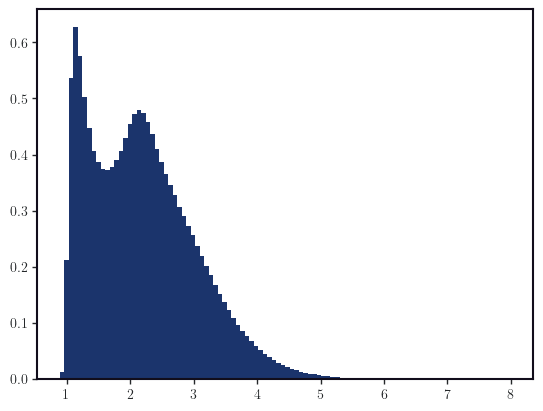

In [2]:
nbparticles = 13
dim = 3
boxlength = (13) ** (1/3)
temp = 1.0
# lj = torch.tensor(np.load(f'lj9_2d_nonperiodic_1.0.npy', mmap_mode='r')[:,:int(10)])
# data = np.load('lj9_2d_nonperiodic_1.0.npy', mmap_mode='r')
data = np.load('lj13_3d_nonperiodic_1.0.npy', mmap_mode='r')
# lj = torch.tensor(data)
lj = torch.tensor(
  rearrange(
    data,
    's b p d -> (s b) p d'
    )
  )
# center them
# lj-= lj.mean(dim=1, keepdim=True)
# lj = torch.tensor(np.load(f'/home/klinger/Dropbox/Travail/Rotskoff/Projects/Marylou/realNVPtests/20250520_lj_samples/lj9_2d_{temp}.npy'))
ljsystem = LJ(
  nparticles=nbparticles,
  dim=dim,
  device='cpu',

                #   boxlength=10 * boxlength,
  # boxlength= 13 ** (1/3),
  boxlength= boxlength,
  kT=1.0,
                  # epsilon=1.,
                  # sigma=1.,
                  # cutoff=3,
                  # shift=False,
  spring_constant = 1.0,
  periodic=False
                  )


# lj-=lj.mean(dim=1, keepdim=True)
ref_potential = ljsystem.potential(lj, turn_off_harmonic=True).flatten()
ref_bin, ref_g_r = ljsystem.g_r(lj, bins=200)

# pairwise distances
# x = torch.tensor(lj[:,-1], device=device).reshape(-1, nbparticles, dim)
dists = torch.norm(lj.unsqueeze(2) - lj.unsqueeze(1), dim=-1)  # shape (batch, N, N)
mask = ~torch.eye(lj.shape[1], device=lj.device).bool()
dists = dists[:, mask].reshape(-1)
plt.hist(dists.cpu().numpy(), bins=100, density=True)
# plt.yscale('log')
plt.show()


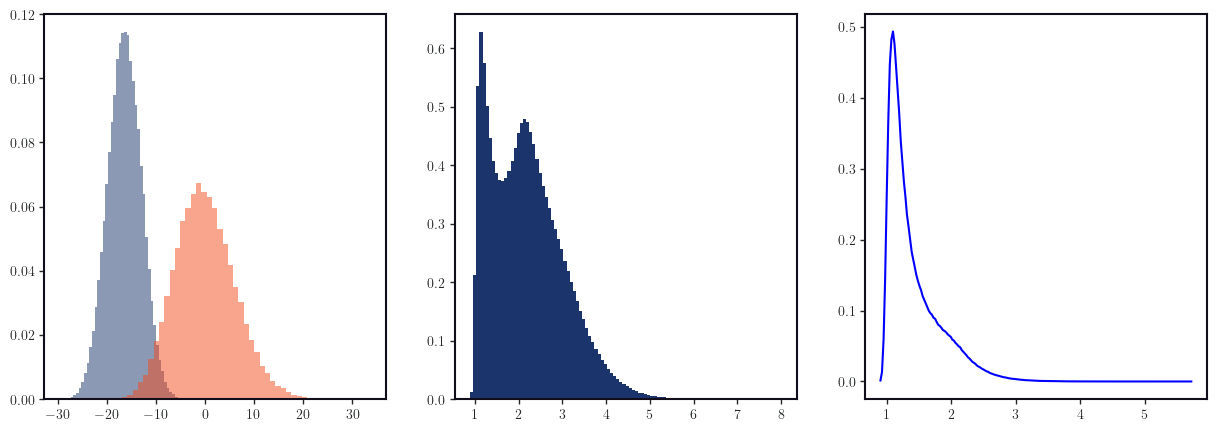

% of sub 0 ref energy confs : 100.0



In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(ref_potential.cpu().numpy(), bins=50, density=True, alpha=0.5, label='Reference samples')
ax[0].hist(ljsystem.potential(lj, turn_off_harmonic=False).cpu().numpy(), bins=50, density=True, alpha=0.5, label='Reference samples')
# ax[0].hist(ref_potential_2.cpu().numpy(), bins=100, density=True, alpha=0.5, label='Reference samples')
# ax[0].show()


ax[1].hist(dists.cpu().numpy(), bins=100, density=True)

ax[2].plot(ref_bin[:-1], ref_g_r, label='Reference samples', color='blue')
# ax[1].set_yscale('log')
plt.show()

print(f'% of sub 0 ref energy confs : {((ref_potential < 0).sum() / ref_potential.shape[0]) * 100}\n')

The rdf really makes no sense to me... Need to look at the code.

- check shape of samples

energy : -12.661377906799316
energy : -13.547187805175781


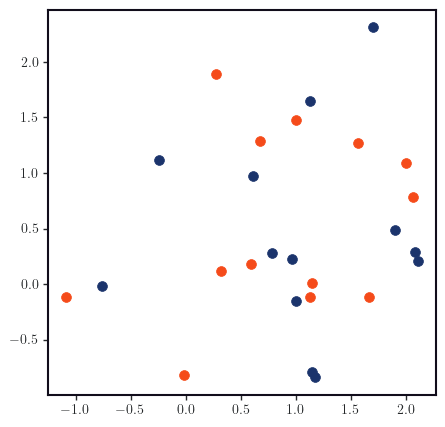

In [4]:
figure = plt.figure(figsize=(5, 5))
for index in range(0, 100, 60):
# boxlength = 3.0
    print(f'energy : {ljsystem.potential(lj[index], turn_off_harmonic=True)}')
    plt.scatter(lj[index,:, 2], lj[index,:, 1] , s=50)
# plt.scatter(lj[index,:, 0] % boxlength, lj[index,:, 1] % boxlength , s=50)

- 3d plot

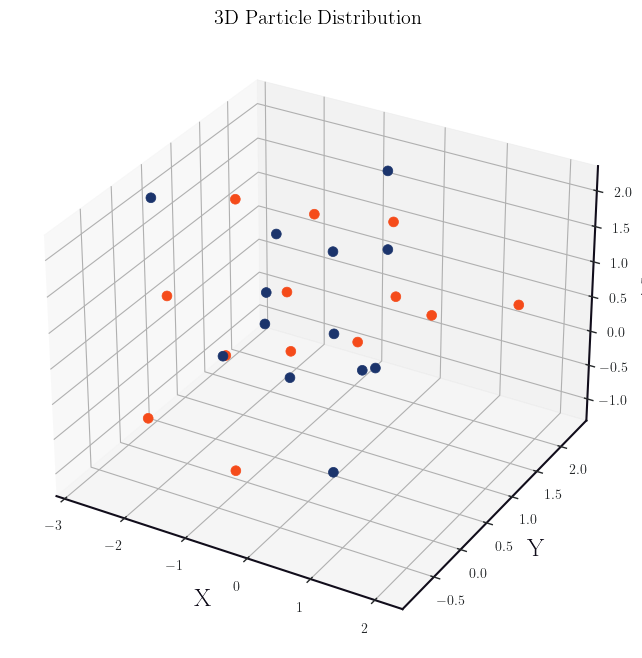

In [5]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for index in range(0, 100, 60):
    x = lj[index,:, 0].cpu().numpy()
    y = lj[index,:, 1].cpu().numpy()
    z = lj[index,:, 2].cpu().numpy()
    ax.scatter(x, y, z,
    # cmap='viridis'
     alpha=1.0, s=50)

# Create 3D plot


# Plot particles


# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Particle Distribution')

plt.show()

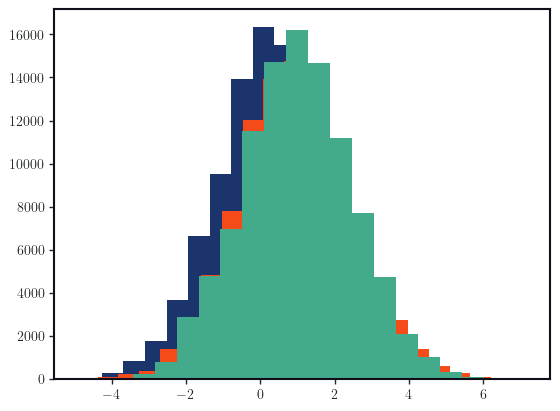

In [6]:
plt.hist(lj.mean(dim=1)[:,0].cpu().numpy(), bins = 20)
plt.hist(lj.mean(dim=1)[:,1].cpu().numpy(), bins = 20)
plt.hist(lj.mean(dim=1)[:,2].cpu().numpy(), bins = 20)
plt.show()

- define flow sampler

In [7]:
vellocitynet=EqTransformerFlowLJ(
    input_dim=dim,
    embed_dim=256
)

velociTrainer = FlowTrainer(flow_model = vellocitynet)


ckpt_path='flow_model_learning_rate_0.0001_batch_size_256_nb_epochs_100_hidden_dim_256_temp_1.0/lightning_logs/version_66935860/checkpoints/epoch=99-step=31300.ckpt'
# # fumble with keynames
ckpt = torch.load(ckpt_path, map_location='cuda')
update_list = [(f"flow_model.{'.'.join(k.split('.')[1:])}",k) for k in ckpt['state_dict'].keys()]
ckpt['state_dict'] = {k1: ckpt['state_dict'][k2] for k1, k2 in update_list} # rename everything
velociTrainer.load_state_dict(ckpt['state_dict'])
# # velociTrainer = FlowTrainer.load_from_checkpoint(flow_model = velocitynet) #
vellocitynet = velociTrainer.flow_model.to(device)
# print(f"nb params : {sum(p.numel() for p in velociTrainer.parameters())}")

/home/klinger/anaconda3/envs/torchtrial/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'flow_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['flow_model'])`.


In [8]:
def logprob0(x, scale):
    """
    x : (batch, p, dim)
    """
    return - reduce(x**2, 'b p d -> b', 'sum') / (2 * scale**2)


In [9]:
x0 = torch.randn(10,13,3).to(device)
t0 = torch.rand(x0.shape[0]).to(x0)

In [10]:
vellocitynet.divergence(x0, t0).shape

torch.Size([10])

In [11]:
%%time
batch_size = 200
nparticles = 13
dim = 3
xt = []
target_log_prob = []
for k in range(5):
    if k % 2 == 0:
        print(k)
    # x0 = gen_sorted_gaussian(batch_size, nbparticles, dim, noise_scale = 0.5).to(device)
    x0 = torch.randn(batch_size, nparticles, dim).to(device) * 1.0
    x0 -= x0.mean(dim=1, keepdim=True)  # center the particles
    # x0 = x0[torch.arange(x0.size(0)).unsqueeze(-1), torch.argsort(x0[:, :, 0], dim=1)]
    xt_, curr_trace = vellocitynet.sample_logprob(x0, n_steps=3)
    target_log_prob_ = logprob0(x0, 1.0) - curr_trace  # assuming scale is 1.0
    xt.append(xt_.detach())
    target_log_prob.append(target_log_prob_.detach())
xt = rearrange(xt, 'l b p d -> (l b) p d')
target_log_prob = rearrange(target_log_prob, 'l b -> (l b)')
xt_bin, xt_g_r = ljsystem.g_r(xt, bins=100)

0
2
4
CPU times: user 94.5 ms, sys: 19 ms, total: 113 ms
Wall time: 114 ms


- show samples

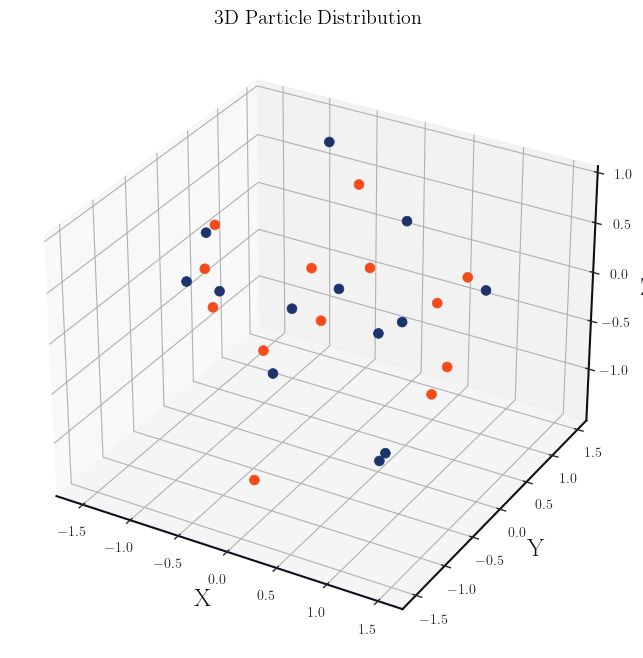

In [20]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for index in range(0, 100, 50):
    x = xt[index,:, 0].cpu().numpy()
    y = xt[index,:, 1].cpu().numpy()
    z = xt[index,:, 2].cpu().numpy()
    ax.scatter(x, y, z,
    # cmap='viridis'
     alpha=1.0, s=50)

    x = lj[index,:, 0].cpu().numpy()
    y = lj[index,:, 1].cpu().numpy()
    z = lj[index,:, 2].cpu().numpy()
    # ax.scatter(x, y, z,
    # # cmap='viridis'
    #  alpha=1.0, s=50)
# Create 3D plot


# Plot particles


# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Particle Distribution')

plt.show()

In [22]:
xt_bin, xt_g_r = ljsystem.g_r(xt, bins=100)
dists_v = torch.norm(xt.unsqueeze(2) - xt.unsqueeze(1), dim=-1)  # shape (batch, N, N)
mask = ~torch.eye(xt.shape[1], device=xt.device).bool()
dists_v = dists_v[:, mask].reshape(-1)

velocity_potential = ljsystem.potential(xt, turn_off_harmonic=True)
weight_potential = ljsystem.potential(xt, turn_off_harmonic=False)
# weights = torch.exp(- temp * weight_potential) / torch.exp(target_log_prob)
# weights /= weights.max()  # shift weights

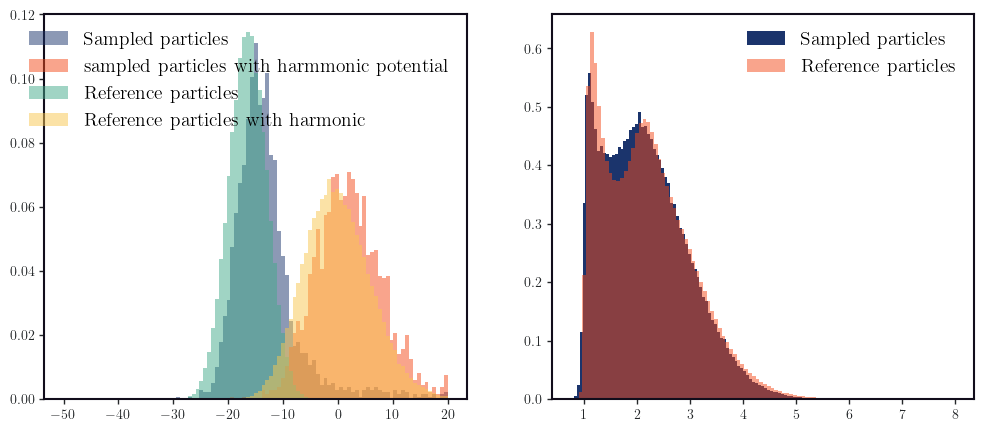

In [24]:
fix, ax = plt.subplots(1, 2, figsize=(12, 5))

bins = np.linspace(-50, 20, 100)
ax[0].hist(velocity_potential.cpu().numpy(),bins=bins,density=True, alpha=0.5, label='Sampled particles')
ax[0].hist(weight_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='sampled particles with harmmonic potential')

ax[0].hist(ref_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Reference particles')
ax[0].hist(ljsystem.potential(
    lj, turn_off_harmonic=False
).cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Reference particles with harmonic')
ax[0].legend()



ax[1].hist(dists_v.cpu().numpy(), bins=100, density=True, label='Sampled particles')
ax[1].hist(dists.cpu().numpy(), bins=100, density=True, alpha=0.5, label='Reference particles')
ax[1].legend()
plt.show()

watch out, rdf and dists don't really give the same type of curves.

In [41]:
weights.sum()

tensor(1.7180, device='cuda:0')

- test raw samples

In [43]:
(velocity_potential < -30).sum() / velocity_potential.shape[0]

tensor(0.0005, device='cuda:0')

In [96]:
velocity_potential

tensor([ -2.6608, -22.3901, -21.8167,  ..., -23.7765, -17.9112, -18.1283],
       device='cuda:0')

- weight

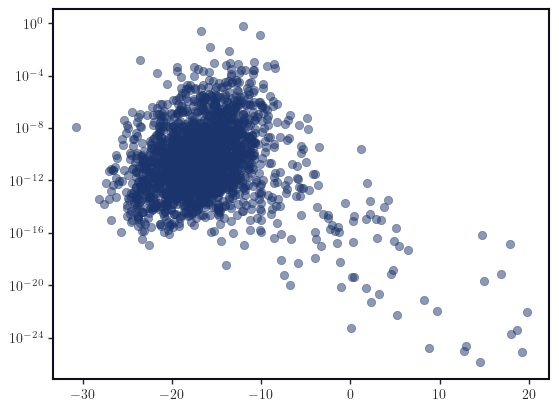

In [45]:
weights_norm = weights / weights.sum()
plt.scatter(velocity_potential[velocity_potential<20].cpu().numpy(), weights_norm[[velocity_potential<20]].cpu().numpy(), alpha=0.5, label='Flow - MC samples')
plt.yscale('log')

- effective smaple size

In [44]:
weights_norm = weights / weights.sum()

print(f'EFF : {(1 / (weights_norm ** 2).sum()) / weights.shape[0]}')

EFF : 0.0011889374582096934


- weighted histogram

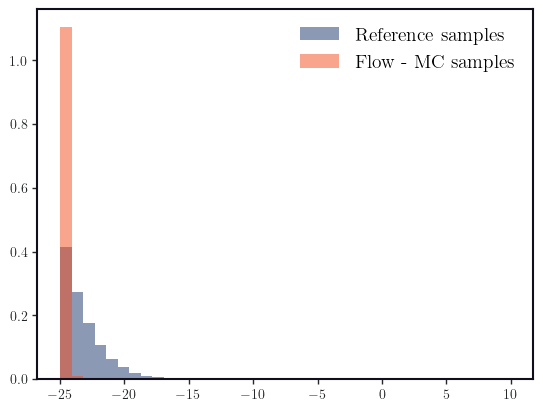

In [60]:
bins = np.linspace(-25, 10, 40)
plt.hist(ref_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Reference samples')
plt.hist(velocity_potential.cpu().numpy(), weights=weights.cpu().numpy(), bins = bins, density=True, alpha=0.5, label='Flow - MC samples')
# plt.yscale('log')
plt.legend()
plt.show()
# print(f"% of sub 0 flow energy confs : {((velocity_potential < 0).sum() / velocity_potential.shape[0]) * 100}\n")

looks pretty good now ! 
- rdf


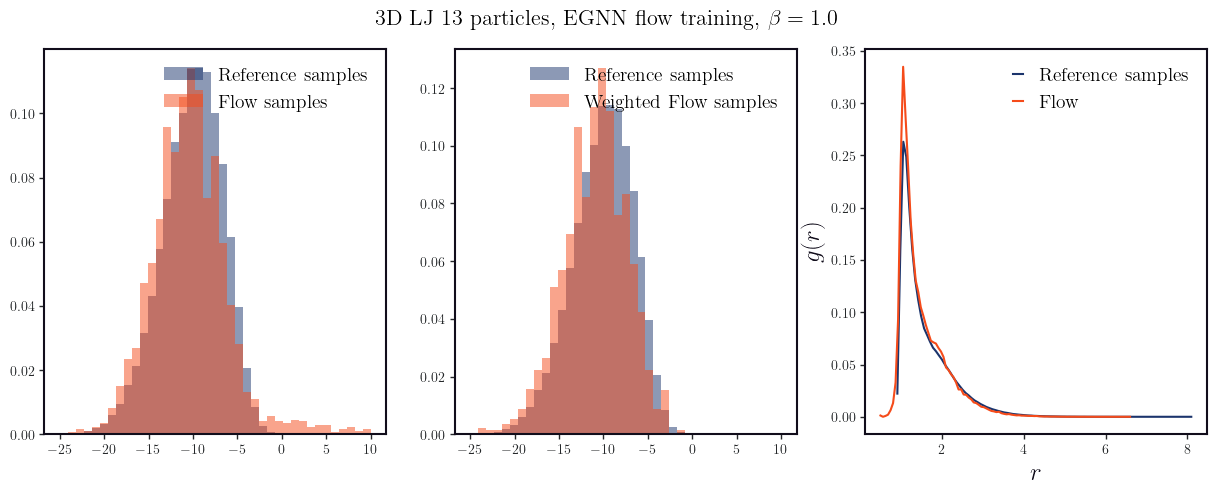

In [ ]:

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle(r'3D LJ 13 particles, EGNN flow training, $\beta = 1.0$', fontsize = 16, y = 0.96)
bins = np.linspace(-25, 10, 40)
ax[0].hist(ref_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Reference samples')
ax[0].hist(velocity_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Flow samples')
# ax[0].set_yscale('log')
ax[0].legend()

bins = np.linspace(-25, 10, 40)
ax[1].hist(ref_potential.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Reference samples')
ax[1].hist(velocity_potential.cpu().numpy(), weights=weights.cpu().numpy(), bins=bins, density=True, alpha=0.5, label='Weighted Flow samples')
ax[1].legend()

ax[2].plot(ref_bin[:-1], ref_g_r, label='Reference samples')
ax[2].plot(xt_bin[:-1], xt_g_r, label='Flow')

# ax[2].set_yscale('log')
ax[2].legend(handlelength=0.5, loc='upper right')
ax[2].set_xlabel(r'$r$')
ax[2].set_ylabel(r'$g(r)$')

temp = 1.0
fname = f'lj13_3d_egnn_flowtraining_{temp}_v1'
# plt.savefig(f'../figures/{fname}.png', bbox_inches='tight')

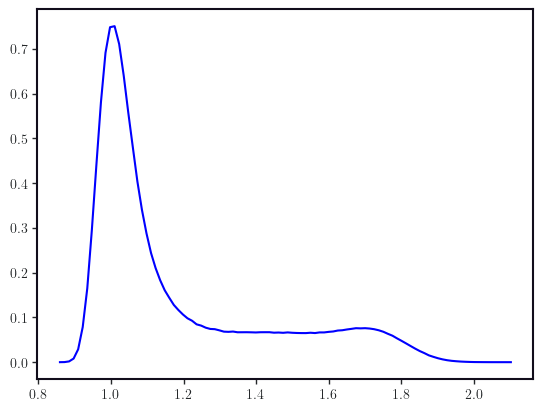

In [102]:
plt.plot(
    ref_bin[:-1],
    ref_g_r,
    label='Reference samples',
    color='blue',
)

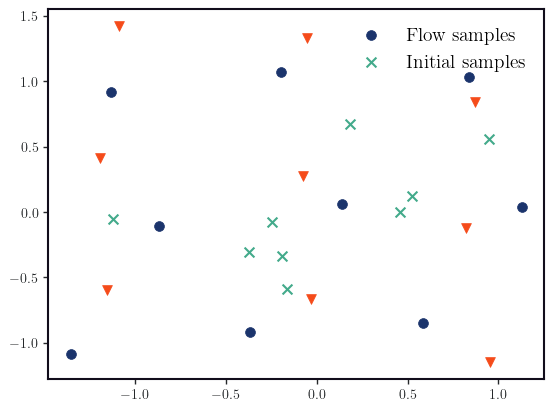

In [103]:
for k in range(2,3):
    plt.scatter(
        xt[k, :, 0].cpu().numpy(),
        xt[k, :, 1].cpu().numpy(),
        s=50,
        label='Flow samples',
        )

    plt.scatter(
        lj[k, :, 0].cpu().numpy() - 1.5,
        lj[k, :, 1].cpu().numpy() - 1.5,
        s=50,
        marker = 'v')
    plt.scatter(
        x0[k, :, 0].cpu().numpy(),
        x0[k, :, 1].cpu().numpy(),
        s=50,
        marker = 'x',
        label='Initial samples',
        )
plt.legend()

# check the mean flow field values

In [126]:
lj -= boxlength / 2
target_data_new = lj.clone().detach().to(device)
target_data_new = target_data_new[torch.arange(target_data_new.size(0)).unsqueeze(-1), torch.argsort(target_data_new[:, :, 0], dim=1)] # sort by x

# prepare the random source data
rd_data = torch.randn_like(target_data_new).to(target_data_new) * 0.5
rd_data = rd_data[torch.arange(rd_data.size(0)).unsqueeze(-1), torch.argsort(rd_data[:, :, 0], dim=1)] # sort by x
rd_cm = repeat(reduce(rd_data, 'b p d -> b 1 d', 'mean'), 'b 1 d -> b p d', p=nbparticles)
rd_data = rd_data - rd_cm

dataset = torch.utils.data.TensorDataset(rd_data, target_data_new)
nb_data = len(dataset)

# split data into test and train
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [144]:
vellocitynet.eval().to(device)
v_ref = []
v_mlp = []
losses = []
losses_bis = []
for i, b in enumerate(train_loader):
    loss = velociTrainer.training_step(b,i)
    losses.append(loss.item())
    # break
    x0, x1  = b #(nbatch, part, dim)
    v = x1-x0
    # break
    t = torch.rand((x0.shape[0], 1)).to(x0)
    t_r = repeat(t , 'b 1-> b p d', p=x0.shape[1], d=x0.shape[2])
    v_ref.append((x1 - x0).norm(p=2, dim=(1,2)).mean())
    xt = x0 + t_r * (x1 - x0)
    v_mlp_ = vellocitynet(xt, t) * 1.3
    losses_bis.append(nn.MSELoss()(v_mlp_, v))
    v_mlp.append(v_mlp_.norm(p=2, dim=(1,2)).mean())
    # print(t[0])
    # break
v_ref = torch.stack(v_ref)
v_mlp = torch.stack(v_mlp)
losses = torch.tensor(losses)
losses_bis = torch.tensor(losses_bis)

/home/klinger/anaconda3/envs/torchtrial/lib/python3.12/site-packages/pytorch_lightning/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [145]:
losses.mean(), losses_bis.mean()

(tensor(0.2005), tensor(0.2396))

In [146]:
print(f'ref norm {v_ref.mean()}), std {v_ref.std()}')
print(f'mlp norm {v_mlp.mean()})n std {v_mlp.std()}')
print(f'diff squared : {((v_ref - v_mlp).mean()) ** 2}')

ref norm 3.291496753692627), std 0.05580444633960724
mlp norm 3.4640185832977295)n std 0.10427957028150558
diff squared : 0.029763849452137947
